**1. Оценка качества классификации текстовых данных**

1. Загрузка исходных данных

In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

start = time.time()

# Создаем список комментариев (объектов)
files = list(open('D:\\Python\\Задачи\\Python\\review_polarity\\reviews.txt'))

# Создаем списки features и labels
y = []
x = []
for i in files:
    y.append(int(i[0]))
    x.append(i[2:-2])

y = np.array(y)

os.chdir('D:\\Python\\Задачи\\Python\\review_polarity\\')

2. Разбивка загруженных данных на обучающее и тестовое подмножества в соотношении 80 / 20%

In [2]:
# Делим данные на тренировочную и тестовую части в соотношении 80/20%
x_train, x_test, y_train, y_test =\
    train_test_split(x, y, test_size=0.2, random_state=123)

3. Векторизация текстовых данных при помощи TF-IDF преобразования

In [3]:
# Создаем объект TFIDF vectorizer и применяем его к тренировочному массиву
tfidf_vectorizer = TfidfVectorizer(input='content', lowercase=True,
                                   ngram_range=(1,1))

tfidf_vectors_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_vectors_test = tfidf_vectorizer.transform(x_test)

4. Построение на обучающем подмножестве моделей классификации:
K-ближайших соседей ($n=5$),
Логистическая регрессия ($C=1$),
Наивный Байес: модель Бернулли ($\alpha=1$),
Наивный Байес: полиномиальная модель ($\alpha=1$).

In [4]:
# model обучает заданный классификатор и рассчитывает score, возвращает список значений метрик
def model(algorithm, x_train, x_test, y_train, y_test):
    # Обучаем классификатор на тренировочных данных
    start = time.time()
    algorithm.fit( x_train, y_train )
    stop = time.time()
    learn_time = stop - start

    # Рассчитываем значения меток для тренировочного и тестового множеств
    start_train_time = time.time()
    y_pred_train = algorithm.predict( x_train )
    start_test_time = time.time()
    y_pred_test = algorithm.predict( x_test )
    stop = time.time()
    predict_time_train = start_test_time - start_train_time
    predict_time_test = stop - start_test_time

    # Метрики
    
    balanced_accuracy_train = balanced_accuracy_score(y_train, y_pred_train)
    balanced_accuracy_test = balanced_accuracy_score(y_test, y_pred_test)
    
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)

    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)

    data_train = [balanced_accuracy_train, accuracy_train, r2_train, precision_train,
                f1_train, learn_time, predict_time_train]
    data_test = [balanced_accuracy_test, accuracy_test, r2_test, precision_test,
                f1_test, learn_time, predict_time_test]
    
    return data_train, data_test

# model_all обучает 4 классификатора (knn, log_regression, bernoulliNB, multinomialNB) при заданных параметрах и возвращает
# датафрейм, столбцы которого соответствуют моделям, а строки - метрикам
def model_all(ngram, parameter, x_train, x_test, y_train, y_test):
    
    knn = KNeighborsClassifier(n_neighbors=parameter[0])
    result_knn = model(knn, x_train, x_test, y_train, y_test)
    knn_best_train = result_knn[0]
    knn_best_test = result_knn[1]
    knn_best_train.append(parameter[0])
    knn_best_test.append(parameter[0])
    
    logregressor = LogisticRegression(penalty='l2', fit_intercept=True,
                        max_iter=100, C=parameter[1], solver='lbfgs', random_state=12345)
    result_log = model(logregressor, x_train, x_test, y_train, y_test)
    log_best_train = result_log[0]
    log_best_test = result_log[1]
    log_best_train.append(parameter[1])
    log_best_test.append(parameter[1])

    bernoulli_classifier = BernoulliNB(alpha=parameter[2],
                                       binarize=0)
    result_bernoulli = model(bernoulli_classifier, x_train, x_test, y_train, y_test)
    bernoulli_best_train = result_bernoulli[0]
    bernoulli_best_test = result_bernoulli[1]
    bernoulli_best_train.append(parameter[2])
    bernoulli_best_test.append(parameter[2])

    multi_classifier = MultinomialNB(alpha=parameter[3])
    result_multi = model(multi_classifier, x_train, x_test, y_train, y_test)
    multi_best_train = result_multi[0]
    multi_best_test = result_multi[1]
    multi_best_train.append(parameter[3])
    multi_best_test.append(parameter[3])
    
    data_train = pd.DataFrame(knn_best_train,
        columns=['knn, ngram=' + str(ngram)], index=['balanced_accuracy','accuracy',
        'r2', 'precision', 'f1', 'learning_time', 'prediction_time', 'parameter'])
    data_train['logistic_regression, ngram=' + str(ngram)] = log_best_train
    data_train['Bernoulli_NB, ngram=' + str(ngram)] = bernoulli_best_train
    data_train['multinomial_NB, ngram=' + str(ngram)] = multi_best_train
    
    data_test = pd.DataFrame(knn_best_test,
        columns=['knn, ngram=' + str(ngram)], index=['balanced_accuracy','accuracy',
        'r2', 'precision', 'f1', 'learning_time', 'prediction_time', 'parameter'])
    data_test['logistic_regression, ngram=' + str(ngram)] = log_best_test
    data_test['Bernoulli_NB, ngram=' + str(ngram)] = bernoulli_best_test
    data_test['multinomial_NB, ngram=' + str(ngram)] = multi_best_test
    
    return data_train, data_test

# Задаем параметры моделей и обучаем их на обучающем подмножестве
parameter = (5, 1, 1, 1)
data_score_test = model_all(1, parameter, tfidf_vectors_train, tfidf_vectors_test,
                       y_train, y_test)[1]

end_1 = time.time()
print('task 1: ' + str(end_1 - start))

task 1: 6.429602384567261


5. Определение качества классификации на тестовом подмножестве (Balanced-Accuracy, R2, Precision, F1)

In [5]:
print( 'balanced accuracy:\n {}\n'.format(data_score_test.iloc[0]) )
print( 'R:\n{}\n'.format(data_score_test.iloc[2]) )
print( 'P:\n{}\n'.format(data_score_test.iloc[3]) )
print( 'F1:\n{}\n'.format(data_score_test.iloc[4]) )

balanced accuracy:
 knn, ngram=1                    0.725713
logistic_regression, ngram=1    0.769779
Bernoulli_NB, ngram=1           0.782476
multinomial_NB, ngram=1         0.785284
Name: balanced_accuracy, dtype: float64

R:
knn, ngram=1                   -0.097049
logistic_regression, ngram=1    0.079229
Bernoulli_NB, ngram=1           0.129862
multinomial_NB, ngram=1         0.141114
Name: r2, dtype: float64

P:
knn, ngram=1                    0.718552
logistic_regression, ngram=1    0.759676
Bernoulli_NB, ngram=1           0.787072
multinomial_NB, ngram=1         0.787736
Name: precision, dtype: float64

F1:
knn, ngram=1                    0.730787
logistic_regression, ngram=1    0.774667
Bernoulli_NB, ngram=1           0.781132
multinomial_NB, ngram=1         0.784774
Name: f1, dtype: float64



6. Определение времени обучения и предсказания

In [6]:
print( 'training time:\n{}\n'.format(data_score_test.iloc[5]) )
print( 'prediction time:\n{}\n'.format(data_score_test.iloc[6]) )

training time:
knn, ngram=1                    0.002953
logistic_regression, ngram=1    0.198944
Bernoulli_NB, ngram=1           0.005982
multinomial_NB, ngram=1         0.002995
Name: learning_time, dtype: float64

prediction time:
knn, ngram=1                    0.733039
logistic_regression, ngram=1    0.000000
Bernoulli_NB, ngram=1           0.001995
multinomial_NB, ngram=1         0.000995
Name: prediction_time, dtype: float64



7. Представление всех значений в виде датафрейма

In [7]:
print(data_score_test)

                   knn, ngram=1  logistic_regression, ngram=1  \
balanced_accuracy      0.725713                      0.769779   
accuracy               0.725738                      0.769808   
r2                    -0.097049                      0.079229   
precision              0.718552                      0.759676   
f1                     0.730787                      0.774667   
learning_time          0.002953                      0.198944   
prediction_time        0.733039                      0.000000   
parameter              5.000000                      1.000000   

                   Bernoulli_NB, ngram=1  multinomial_NB, ngram=1  
balanced_accuracy               0.782476                 0.785284  
accuracy                        0.782466                 0.785279  
r2                              0.129862                 0.141114  
precision                       0.787072                 0.787736  
f1                              0.781132                 0.784774  
learni

**2. Оценка качества классификации текстовых данных посредством кросс-валидации**

Повторение предыдущих пунктов с использованием стратифицированной кросс-валидации (k=4) для разделения исходных данных

In [8]:
# kf_score выполняет стратифицированную кросс-валидацию выбранной модели, обучает каждый разрез датасета, находит для
# каждого разреза score, а затем score усредняется по разрезам. Возвращает список со средними значениями метрик
def kf_score(algorithm, X, y, ngram):
    k = 4
    kf = StratifiedKFold(n_splits=k)

    df = pd.DataFrame(X)

    result_train, result_test = [],[]
    
    for train_index, test_index in kf.split(df, y):
        
        x_train_loc, x_test_loc = df.iloc[train_index], df.iloc[test_index]
        y_train_loc, y_test_loc = y[train_index] , y[test_index]
        
        
        tfidf_vectorizer_loc = TfidfVectorizer(input='content', lowercase=True,
                                           ngram_range=ngram)
        
        tfidf_vectors_train_loc = tfidf_vectorizer_loc.fit_transform(x_train_loc[0])
        
        tfidf_vectors_test_loc = tfidf_vectorizer_loc.transform(x_test_loc[0])

        
        result = np.array( model(algorithm,  tfidf_vectors_train_loc,
                        tfidf_vectors_test_loc, y_train_loc, y_test_loc) )
        result_train.append( result[0] )
        result_test.append( result[1] )
    
    result_train = np.array(result_train)
    result_test = np.array(result_test)
        
    results_train = result_train.mean(axis=0)
    results_test = result_test.mean(axis=0)
    
    return results_train, results_test

# Создаем классификаторы
knn = KNeighborsClassifier(n_neighbors=parameter[0])
logregressor = LogisticRegression(penalty='l2', fit_intercept=True,
                    max_iter=100, C=parameter[1], solver='lbfgs', random_state=12345)
bernoulli_classifier = BernoulliNB(alpha=parameter[2],
                                   binarize=0)
multi_classifier = MultinomialNB(alpha=parameter[3])

# Рассчитываем score для каждой модели и добавляем в датафрейм
data_score_kf = pd.DataFrame(kf_score(knn, x_train, y_train, (1,1))[1],
                columns=['knn'],index=['balanced_accuracy','accuracy',
                'r2', 'precision', 'f1', 'learning_time', 'prediction_time'])

data_score_kf['logistic_regression'] = kf_score(logregressor, x_train, y_train, (1,1))[1]
data_score_kf['Bernoulli_NB'] = kf_score(bernoulli_classifier, x_train, y_train, (1,1))[1]
data_score_kf['multinomial_NB'] = kf_score(multi_classifier, x_train, y_train, (1,1))[1]


end_2 = time.time()
print('task 2: ' + str(end_2 - end_1))

print(data_score_kf)

task 2: 24.31314778327942
                        knn  logistic_regression  Bernoulli_NB  multinomial_NB
balanced_accuracy  0.696450             0.747800      0.765030        0.766084
accuracy           0.696447             0.747801      0.765037        0.766093
r2                -0.214211            -0.008797      0.060148        0.064370
precision          0.694525             0.745340      0.772011        0.774965
f1                 0.697678             0.749120      0.761992        0.762302
learning_time      0.001745             0.130892      0.005237        0.004488
prediction_time    0.685903             0.000249      0.001497        0.000744


**3. Выбор наилучших моделей для каждого метода в зависимости от гиперпараметров**

1. Разбивка обучающего подмножества посредством стратифицированной кросс-валидации (k=4). Обучение и тестирование на разбитом обучающем подмножестве классификаторов с параметрами:
количество соседей: np.arange(1, 150, 20)
параметр регуляризации: np.logspace(-2, 10, 8, base=10)
сглаживающий параметр: np.logspace(-4, 1, 8, base=10)

In [9]:
# Задаем диапазоны параметров моделей
k_knn = np.arange(1, 150, 20)
C = np.logspace(-2, 10, 8, base=10)
alpha = np.logspace(-4, 1, 8, base=10)

# Разбиваем обучающее подмножество с помощью стратифицированной кросс-валидации с k=4, обучаем модели и находим значения метрик
# для каждого из значений параметров
scores_knn_train, scores_knn_test = [],[]
for i in k_knn:
    knn = KNeighborsClassifier(n_neighbors=i)
    result = kf_score(knn, x_train, y_train, (1,1))
    scores_knn_train.append( result[0][0] )
    scores_knn_test.append( result[1][0] )
    
scores_log_train, scores_log_test = [],[]
for i in C:
    logregressor = LogisticRegression(penalty='l2', fit_intercept=True,
                        max_iter=1000, C=i, solver='lbfgs', random_state=12345)
    result = kf_score(logregressor, x_train, y_train, (1,1))
    scores_log_train.append( result[0][0] )
    scores_log_test.append( result[1][0] )

scores_bernoulli_train, scores_bernoulli_test = [],[]
for i in alpha:
    bernoulli_classifier = BernoulliNB(alpha=i, binarize=0)
    result = kf_score(bernoulli_classifier, x_train, y_train, (1,1))
    scores_bernoulli_train.append( result[0][0] )
    scores_bernoulli_test.append( result[1][0] )
    
scores_multi_train, scores_multi_test = [],[]
for i in alpha:
    multi_classifier = MultinomialNB(alpha=i)
    result = kf_score(multi_classifier, x_train, y_train, (1,1))
    scores_multi_train.append( result[0][0] )
    scores_multi_test.append( result[1][0] )

In [10]:
print('knn n_neighbours: {}\n'.format(scores_knn_test))
print('log C: {}\n'.format(scores_log_test))
print('bernoulliNB alpha: {}\n'.format(scores_bernoulli_test))
print('multinomualNB alpha: {}\n'.format(scores_multi_test))

knn n_neighbours: [0.660806450449849, 0.7262311721805483, 0.7357288607513492, 0.7395964890102397, 0.7381877098513604, 0.7387736828601023, 0.7296296482153453, 0.7289265220460704]

log C: [0.6908153226260955, 0.7385379515844921, 0.7535464571875962, 0.7385398208763722, 0.7336150863376956, 0.7378369147087696, 0.7446335352280009, 0.7442819732784566]

bernoulliNB alpha: [0.7166098460753555, 0.7182513876223658, 0.7216510712929824, 0.730444643171033, 0.7470927109252409, 0.75928618647558, 0.7649130576919588, 0.744741009346868]

multinomualNB alpha: [0.7135646928290013, 0.7141509971817249, 0.7181368751010387, 0.7285720988365065, 0.7492057146107107, 0.7647967857763974, 0.7670207858776725, 0.7508373618611359]



2. Построение графиков (параметры модели vs Balanced-Accuracy)

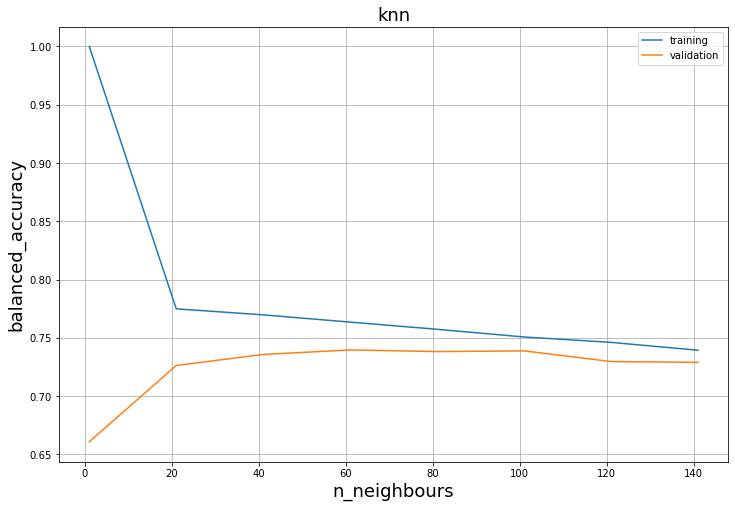

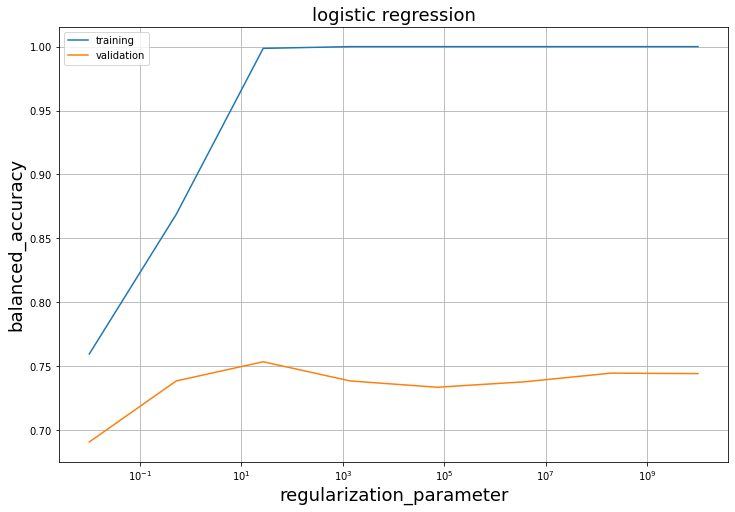

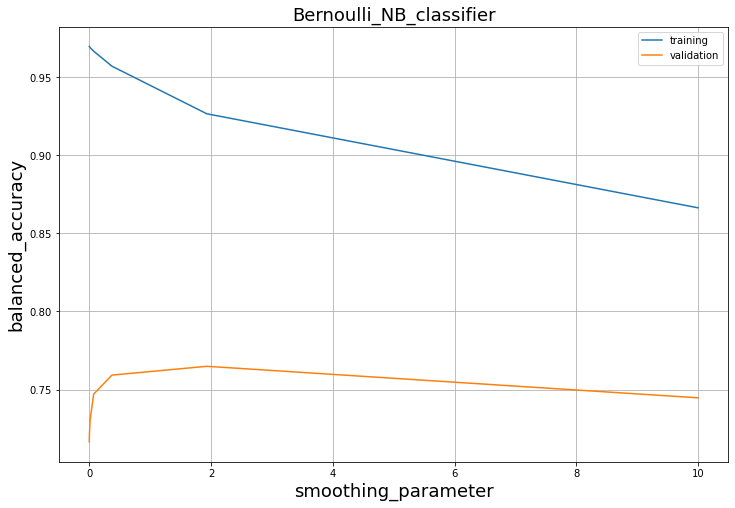

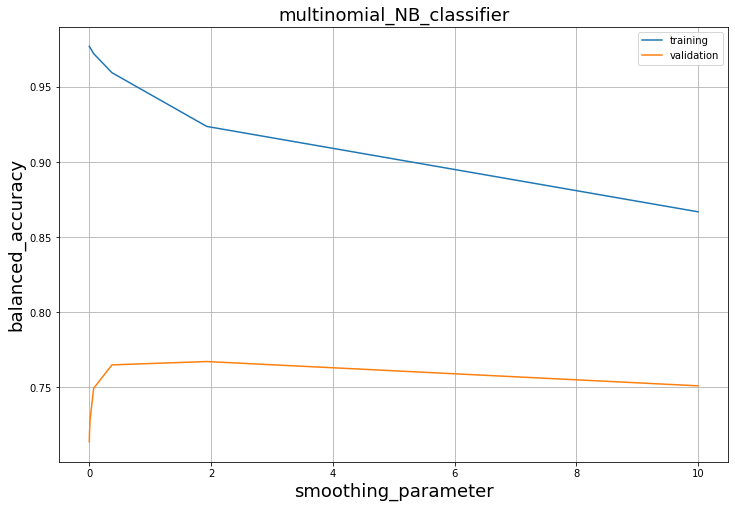

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(k_knn, scores_knn_train, label='training')
plt.plot(k_knn, scores_knn_test, label='validation')
ax.set_xlabel('n_neighbours', fontsize=18)
ax.set_ylabel('balanced_accuracy', fontsize=18)
plt.title( 'knn' , fontsize=18 )
plt.grid()
plt.legend()

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(C, scores_log_train, label='training')
plt.plot(C, scores_log_test, label='validation')
ax.set_xlabel('regularization_parameter', fontsize=18)
ax.set_ylabel('balanced_accuracy', fontsize=18)
ax.set_xscale ('log')
plt.title( 'logistic regression' , fontsize=18 )
plt.grid()
plt.legend()

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(alpha, scores_bernoulli_train, label='training')
plt.plot(alpha, scores_bernoulli_test, label='validation')
ax.set_xlabel('smoothing_parameter', fontsize=18)
ax.set_ylabel('balanced_accuracy', fontsize=18)
plt.title( 'Bernoulli_NB_classifier' , fontsize=18 )
plt.grid()
plt.legend()

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(alpha, scores_multi_train, label='training')
plt.plot(alpha, scores_multi_test, label='validation')
ax.set_xlabel('smoothing_parameter', fontsize=18)
ax.set_ylabel('balanced_accuracy', fontsize=18)
plt.title( 'multinomial_NB_classifier' , fontsize=18 )
plt.grid()
plt.legend()

3. Выбор лучшей модели для каждого метода на основе значений Balanced-Accuracy

In [12]:
# Выбираем параметры, при которых получены наилучшие результаты
n_best = k_knn[ scores_knn_test.index( max(scores_knn_test) ) ]
C_best = C[ scores_log_test.index( max(scores_log_test) ) ]
alpha_bernoulli_best = alpha[ scores_bernoulli_test.index( max(scores_bernoulli_test) ) ]
alpha_multi_best = alpha[ scores_multi_test.index( max(scores_multi_test) ) ]

# Сводим параметры в кортеж
parameter_best_11 = (n_best, C_best, alpha_bernoulli_best, alpha_multi_best)

4. Обучение выбранных моделей на обучающем подмножестве и тестирование на тестовом. Определение времени обучения и предсказания.

In [13]:
# Обучаем модели при найденных параметрах и тестируем
data_score_11 = model_all(1, parameter_best_11, tfidf_vectors_train,
                          tfidf_vectors_test, y_train, y_test)[1]

print( 'training time:\n{}\n'.format(data_score_11.iloc[5]) )
print( 'prediction time:\n{}\n'.format(data_score_11.iloc[6]) )

end_3_1 = time.time()
print('task 3_1: ' + str(end_3_1 - end_2))

training time:
knn, ngram=1                    0.003994
logistic_regression, ngram=1    0.418623
Bernoulli_NB, ngram=1           0.003992
multinomial_NB, ngram=1         0.002002
Name: learning_time, dtype: float64

prediction time:
knn, ngram=1                    0.779951
logistic_regression, ngram=1    0.000000
Bernoulli_NB, ngram=1           0.002993
multinomial_NB, ngram=1         0.000000
Name: prediction_time, dtype: float64

task 3_1: 146.38122868537903


C:\Users\1311117\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5. Выбор лучших моделей (повторение предыдущих шагов) для n-gram=2 и n-gram=(1,2)

C:\Users\1311117\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\1311117\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

task 3_2: 157.52169227600098


C:\Users\1311117\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\1311117\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

task 3: 201.96709942817688


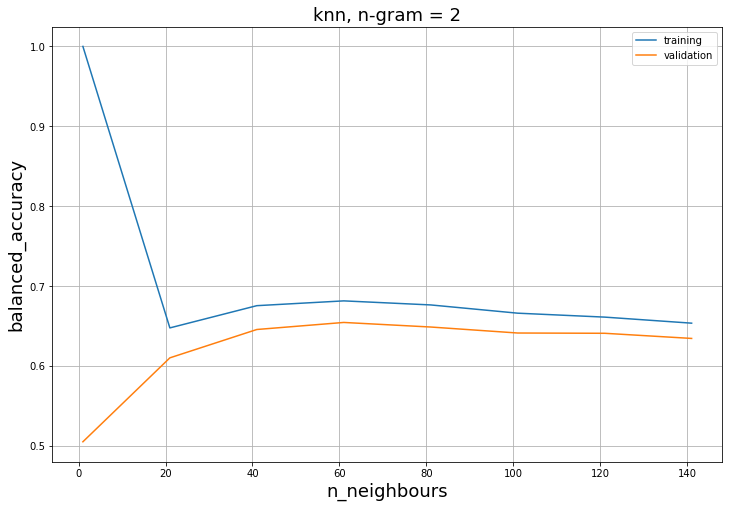

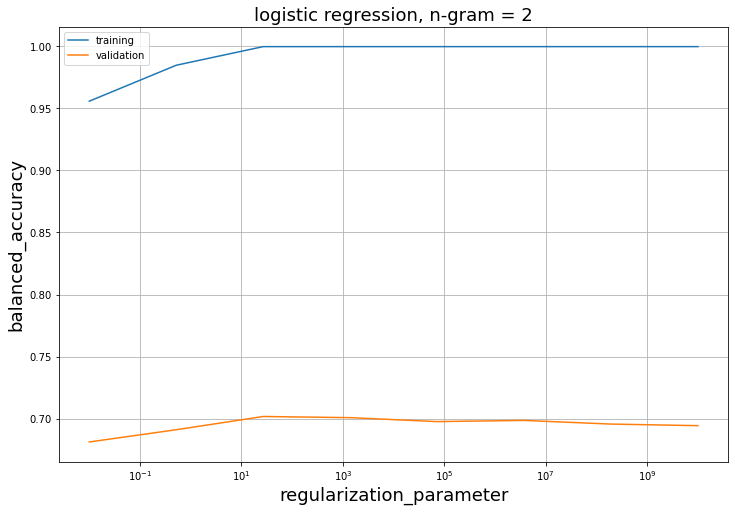

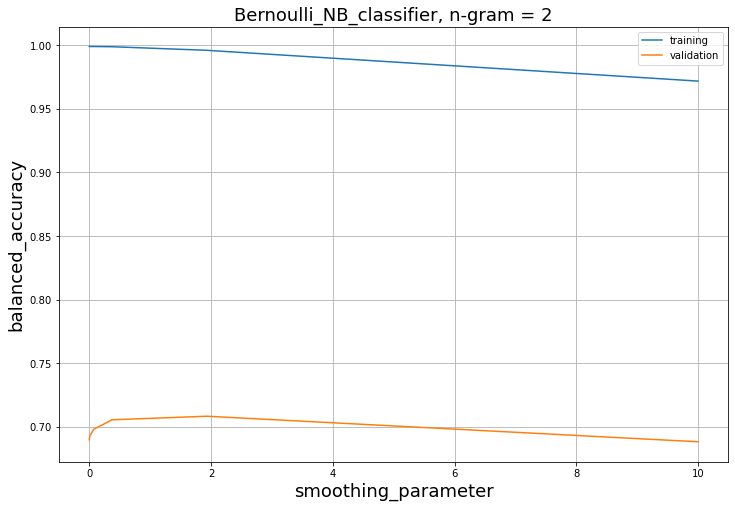

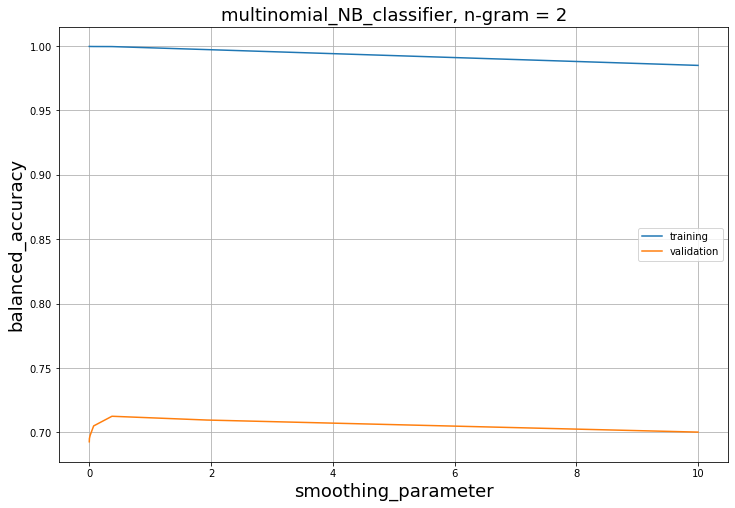

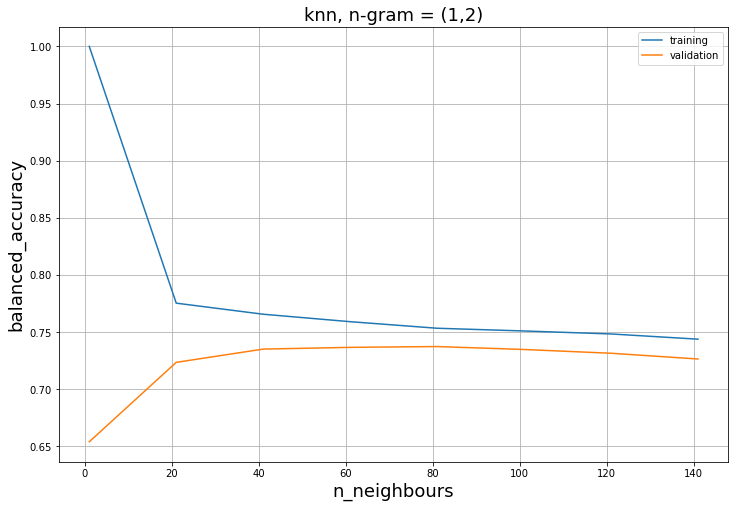

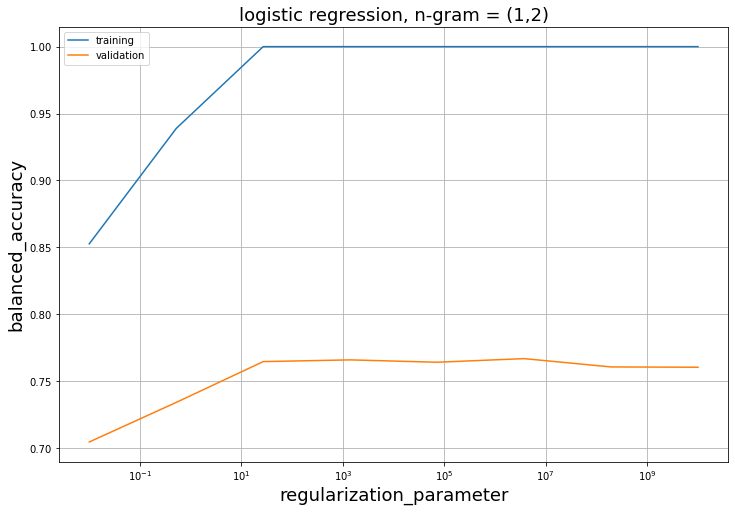

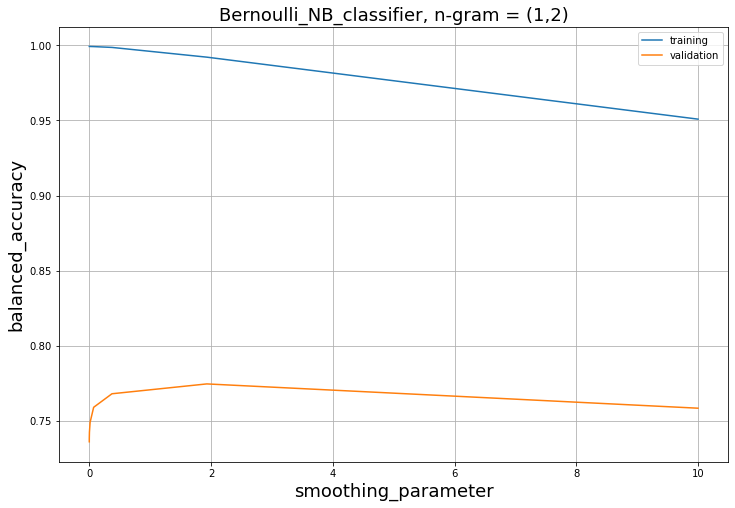

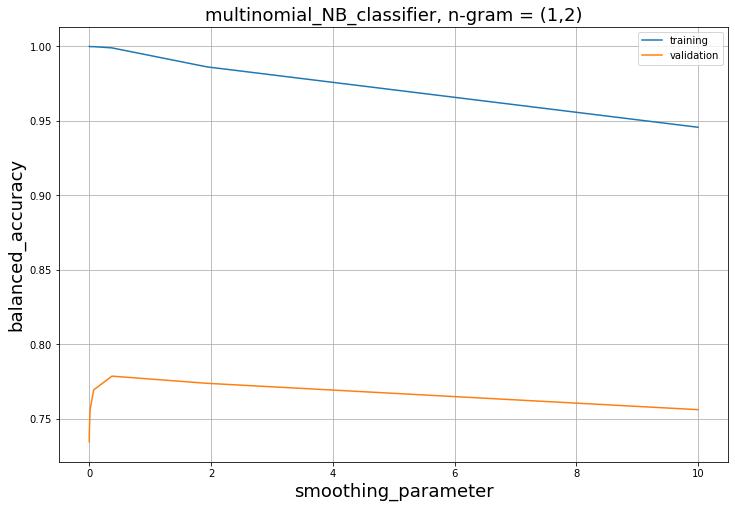

In [14]:
# Векторизируем данные с параметром n-gram = (2,2)
tfidf_vectorizer = TfidfVectorizer(input='content', lowercase=True,
                                   ngram_range=(2,2))

tfidf_vectors_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_vectors_test = tfidf_vectorizer.transform(x_test)

# кросс-валидация и нахождение лучших параметров для модели knn при n-gram = (2,2), построение графика
scores_knn_train_22, scores_knn_test_22 = [],[]
for i in k_knn:
    knn = KNeighborsClassifier(n_neighbors=i)
    result = kf_score(knn, x_train, y_train, (2,2))
    scores_knn_train_22.append( result[0][0] )
    scores_knn_test_22.append( result[1][0] )

n_best_22 = k_knn[ scores_knn_test_22.index( max(scores_knn_test_22) ) ]

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(k_knn, scores_knn_train_22, label='training')
plt.plot(k_knn, scores_knn_test_22, label='validation')
ax.set_xlabel('n_neighbours', fontsize=18)
ax.set_ylabel('balanced_accuracy', fontsize=18)
plt.title( 'knn, n-gram = 2' , fontsize=18 )
plt.grid()
plt.legend()


# кросс-валидация и нахождение лучших параметров для модели log_regression при n-gram = (2,2), построение графика
scores_log_train_22, scores_log_test_22 = [],[]
for i in C:
    logregressor = LogisticRegression(penalty='l2', fit_intercept=True,
                        max_iter=100, C=i, solver='lbfgs', random_state=12345)
    result = kf_score(logregressor, x_train, y_train, (2,2))
    scores_log_train_22.append( result[0][0] )
    scores_log_test_22.append( result[1][0] )

C_best_22 = C[ scores_log_test_22.index( max(scores_log_test_22) ) ]

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(C, scores_log_train_22, label='training')
plt.plot(C, scores_log_test_22, label='validation')
ax.set_xlabel('regularization_parameter', fontsize=18)
ax.set_ylabel('balanced_accuracy', fontsize=18)
ax.set_xscale ('log')
plt.title( 'logistic regression, n-gram = 2' , fontsize=18 )
plt.grid()
plt.legend()


# кросс-валидация и нахождение лучших параметров для модели bernoulliNB при n-gram = (2,2), построение графика
scores_bernoulli_train_22, scores_bernoulli_test_22 = [],[]
for i in alpha:
    bernoulli_classifier = BernoulliNB(alpha=i, binarize=0)
    result = kf_score(bernoulli_classifier, x_train, y_train, (2,2))
    scores_bernoulli_train_22.append( result[0][0] )
    scores_bernoulli_test_22.append( result[1][0] )

alpha_bernoulli_best_22 = alpha[ scores_bernoulli_test_22.index( max(scores_bernoulli_test_22) ) ]

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(alpha, scores_bernoulli_train_22, label='training')
plt.plot(alpha, scores_bernoulli_test_22, label='validation')
ax.set_xlabel('smoothing_parameter', fontsize=18)
ax.set_ylabel('balanced_accuracy', fontsize=18)
plt.title( 'Bernoulli_NB_classifier, n-gram = 2' , fontsize=18 )
plt.grid()
plt.legend()


# кросс-валидация и нахождение лучших параметров для модели multinomialNB при n-gram = (2,2), построение графика
scores_multi_train_22, scores_multi_test_22 = [],[]
for i in alpha:
    multi_classifier = MultinomialNB(alpha=i)
    result = kf_score(multi_classifier, x_train, y_train, (2,2))
    scores_multi_train_22.append( result[0][0] )
    scores_multi_test_22.append( result[1][0] )

alpha_multi_best_22 = alpha[ scores_multi_test_22.index( max(scores_multi_test_22) ) ]

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(alpha, scores_multi_train_22, label='training')
plt.plot(alpha, scores_multi_test_22, label='validation')
ax.set_xlabel('smoothing_parameter', fontsize=18)
ax.set_ylabel('balanced_accuracy', fontsize=18)
plt.title( 'multinomial_NB_classifier, n-gram = 2' , fontsize=18 )
plt.grid()
plt.legend()


# Обучаем модели с использованием лучших параметров для n-gram=(2,2)
parameter_best_22 = (n_best_22, C_best_22, alpha_bernoulli_best_22,
                     alpha_multi_best_22)
data_score_22 = model_all(2, parameter_best_22, tfidf_vectors_train,
                          tfidf_vectors_test, y_train, y_test)[1]

end_3_2 = time.time()
print('task 3_2: ' + str(end_3_2 - end_3_1))


#------------------------------------------------------------------------------
# Векторизируем данные с параметром n-gram = (1,2)
tfidf_vectorizer = TfidfVectorizer(input='content', lowercase=True,
                                   ngram_range=(1,2))

tfidf_vectors_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_vectors_test = tfidf_vectorizer.transform(x_test)

# кросс-валидация и нахождение лучших параметров для модели knn при n-gram = (1,2), построение графика
scores_knn_train_12, scores_knn_test_12 = [],[]
for i in k_knn:
    knn = KNeighborsClassifier(n_neighbors=i)
    result = kf_score(knn, x_train, y_train, (1,2))
    scores_knn_train_12.append( result[0][0] )
    scores_knn_test_12.append( result[1][0] )

n_best_12 = k_knn[ scores_knn_test_12.index( max(scores_knn_test_12) ) ]

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(k_knn, scores_knn_train_12, label='training')
plt.plot(k_knn, scores_knn_test_12, label='validation')
ax.set_xlabel('n_neighbours', fontsize=18)
ax.set_ylabel('balanced_accuracy', fontsize=18)
plt.title( 'knn, n-gram = (1,2)' , fontsize=18 )
plt.grid()
plt.legend()


# кросс-валидация и нахождение лучших параметров для модели log_regression при n-gram = (1,2), построение графика
scores_log_train_12, scores_log_test_12 = [],[]
for i in C:
    logregressor = LogisticRegression(penalty='l2', fit_intercept=True,
                        max_iter=100, C=i, solver='lbfgs', random_state=12345)
    result = kf_score(logregressor, x_train, y_train, (1,2))
    scores_log_train_12.append( result[0][0] )
    scores_log_test_12.append( result[1][0] )

C_best_12 = C[ scores_log_test_12.index( max(scores_log_test_12) ) ]

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(C, scores_log_train_12, label='training')
plt.plot(C, scores_log_test_12, label='validation')
ax.set_xlabel('regularization_parameter', fontsize=18)
ax.set_ylabel('balanced_accuracy', fontsize=18)
ax.set_xscale ('log')
plt.title( 'logistic regression, n-gram = (1,2)' , fontsize=18 )
plt.grid()
plt.legend()


# кросс-валидация и нахождение лучших параметров для модели bernoulliNB при n-gram = (1,2), построение графика
scores_bernoulli_train_12, scores_bernoulli_test_12 = [],[]
for i in alpha:
    bernoulli_classifier = BernoulliNB(alpha=i, binarize=0)
    result = kf_score(bernoulli_classifier, x_train, y_train, (1,2))
    scores_bernoulli_train_12.append( result[0][0] )
    scores_bernoulli_test_12.append( result[1][0] )

alpha_bernoulli_best_12 = alpha[ scores_bernoulli_test_12.index( max(scores_bernoulli_test_12) ) ]

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(alpha, scores_bernoulli_train_12, label='training')
plt.plot(alpha, scores_bernoulli_test_12, label='validation')
ax.set_xlabel('smoothing_parameter', fontsize=18)
ax.set_ylabel('balanced_accuracy', fontsize=18)
plt.title( 'Bernoulli_NB_classifier, n-gram = (1,2)' , fontsize=18 )
plt.grid()
plt.legend()


# кросс-валидация и нахождение лучших параметров для модели multinomialNB при n-gram = (1,2), построение графика
scores_multi_train_12, scores_multi_test_12 = [],[]
for i in alpha:
    multi_classifier = MultinomialNB(alpha=i)
    result = kf_score(multi_classifier, x_train, y_train, (1,2))
    scores_multi_train_12.append( result[0][0] )
    scores_multi_test_12.append( result[1][0] )

alpha_multi_best_12 = alpha[ scores_multi_test_12.index( max(scores_multi_test_12) ) ]

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(alpha, scores_multi_train_12, label='training')
plt.plot(alpha, scores_multi_test_12, label='validation')
ax.set_xlabel('smoothing_parameter', fontsize=18)
ax.set_ylabel('balanced_accuracy', fontsize=18)
plt.title( 'multinomial_NB_classifier, n-gram = (1,2)' , fontsize=18 )
plt.grid()
plt.legend()


# Обучаем модели с использованием лучших параметров для n-gram=(1,2)
parameter_best_12 = (n_best_12, C_best_12, alpha_bernoulli_best_12,
                     alpha_multi_best_12)
data_score_12 = model_all(2, parameter_best_12, tfidf_vectors_train,
                          tfidf_vectors_test, y_train, y_test)[1]


end_3 = time.time()
print('task 3: ' + str(end_3 - end_3_2))

6. Вывод итоговых данных в виде таблиц по всем методам для лучших моделей (метод, n-gram, значение параметра модели, время обучения, время предсказания, метрики (Balanced-Accuracy, R, P, F1))

In [15]:
data_ngram = pd.concat((data_score_11, data_score_22, data_score_12), axis=1)
print(data_ngram)

                   knn, ngram=1  logistic_regression, ngram=1  \
balanced_accuracy      0.758041                      0.769799   
accuracy               0.758087                      0.769808   
r2                     0.032347                      0.079229   
precision              0.742531                      0.766883   
f1                     0.766092                      0.771522   
learning_time          0.003994                      0.418623   
prediction_time        0.779951                      0.000000   
parameter             61.000000                     26.826958   

                   Bernoulli_NB, ngram=1  multinomial_NB, ngram=1  \
balanced_accuracy               0.780600                 0.790906   
accuracy                        0.780591                 0.790905   
r2                              0.122361                 0.163618   
precision                       0.784630                 0.791745   
f1                              0.779453                 0.791003   


7. Выводы по полученным результатам (преимущества и недостатки методов)

knn: ngram=(2,2) дает худшие значения метрик, чем ngram=(1,1) и (1,2), но при этом время обучения и предсказания в данном случае оказывается ниже. Таким образом, при использовании knn значение ngram=(2,2) может быть полезным в случае, если высокая точность не так важна, как скорость обучения и предсказания модели. Значения метрик для ngram=(1,1) и (1,2) близки, при этом времена обучения и предсказания также не имеют сильных отличий, поэтому среди данных моделей нет наиболее предпочтительной.

logistic_regression: ngram=(1,1) показал более высокие значения метрик, чем ngram=(2,2), при этом время обучения и предсказания для ngram=(1,1), соответственно, меньше и примерно равно времени обучения и предсказания для ngram=(2,2), поэтому модель ngram=(1,1) однозначно предпочтительнее ngram=(2,2). Модель ngram=(1,2) показала наиболее высокие значения метрик в совокупности с большим временем обучения, причем данные по времени предсказания отсутствуют. Таким образом, модель с ngram=(1,2) может быть выгодна в случае, когда необходима высокая точность при наличии достаточного времени для обучения модели.

bernoulliNB: по всем метрикам модель с ngram=(1,1) превосходит модель с ngram=(2,2), а время обучения и предсказания в ней значительно ниже, поэтому ngram=(1,1) однозначно лучше ngram=(2,2). Модель с ngram=(1,2) незначительно превосходит по точности предсказания модель с ngram=(1,1), но сильно уступает по времени обучения и предсказания, поэтому среди трех моделей наилучшей является ngram=(1,1).

multinomialNB: ситуация аналогичная с моделью bernoulliNB, поэтому лучшей моделью является ngram=(1,1)

Среди всех приведенных моделей наименьшую точность продемонстрировала модель knn. Логистическая регрессия, при высоких значениях метрик, показала наименьшую скорость обучения, которая на несколько порядков ниже таковой для моделей bernoulliNB и multinomialNB, что может быть существенно при обучении на большой выборке. Модели bernoulliNB и multinomialNB показали схожие друг с другом результаты, которые немного хуже модели логистической регрессии по значениям метрик, но значительно превосходят ее по времени обучения. Таким образом, среди всех моделей в данной задаче наилучшими являются модели bernoulliNB и multinomialNB с ngram=(1,1).

**4. Оценка влияния количества признаков FeatureHasher на качество классификации**

Определение изменения качества классификации для используемых методов при использовании HashingVectorizer перед TF-IDF преобразованием

In [76]:
n_features = np.logspace(1, 4, 4, base=10)
ngram = [(1,1), (2,2), (1,2)]

def score_hash(n_features, ngram, parameter):

    hash_vectorizer = HashingVectorizer(input='content', lowercase=True,
                        ngram_range=ngram, n_features=int(n_features))
    hash_vectors_train = hash_vectorizer.fit_transform(x_train).toarray()
    hash_vectors_test = hash_vectorizer.transform(x_test).toarray()
    
    
    tfidf_transformer = TfidfTransformer(use_idf=True, smooth_idf=True)
    tfidf_vectors_train = tfidf_transformer.fit_transform(hash_vectors_train)
    tfidf_vectors_test = tfidf_transformer.transform(hash_vectors_test)
    
    
    scaler = MinMaxScaler()
    x_transformed_train = scaler.fit_transform(tfidf_vectors_train.toarray())
    x_transformed_test = scaler.transform(tfidf_vectors_test.toarray())
    
    
    data = model_all( ngram, parameter, x_transformed_train , x_transformed_test, y_train, y_test )
    
    return data

dct = {'(1, 1)': parameter_best_11,
       '(2, 2)': parameter_best_22,
       '(1, 2)': parameter_best_12}

data = []
for i in range(len(n_features)):
    data.append([])
    for j in ngram:
        data[i].append( score_hash(n_features[i], j, dct[str(j)]) )
        print(i, j)
        
        
end_4 = time.time()
print('task 4: ' + str(end_4 - end_3))

0 (1, 1)
0 (2, 2)
0 (1, 2)


C:\Users\1311117\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1 (1, 1)
1 (2, 2)
1 (1, 2)


C:\Users\1311117\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2 (1, 1)


C:\Users\1311117\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2 (2, 2)


C:\Users\1311117\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2 (1, 2)


C:\Users\1311117\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3 (1, 1)


C:\Users\1311117\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\1311117\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\1311117\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

3 (2, 2)


C:\Users\1311117\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3 (1, 2)
task 4: 8855.76684999466


In [77]:
# data - двумерный список, в строках которого расположены датафреймы для разных значений n_features, а в столбцах - для разных
# значений n-gram
for i in range(len(n_features)):
    for j in range(len(ngram)):
        print( 'n_features={}, ngram={}\n{}\n\n '.format(n_features[i], ngram[j], data[i][j]) )

n_features=10.0, ngram=(1, 1)
(                   knn, ngram=(1, 1)  logistic_regression, ngram=(1, 1)  \
balanced_accuracy           0.582968                           0.559506   
accuracy                    0.582952                           0.559503   
r2                         -0.668191                          -0.761989   
precision                   0.576176                           0.558161   
f1                          0.600202                           0.563799   
learning_time               0.128562                           0.146337   
prediction_time             2.823787                           0.014000   
parameter                  61.000000                          26.826958   

                   Bernoulli_NB, ngram=(1, 1)  multinomial_NB, ngram=(1, 1)  
balanced_accuracy                    0.500820                      0.551996  
accuracy                             0.500645                      0.551999  
r2                                  -0.997421              

Для всех значений ngram и n_features результаты для HashingVectorizer оказались хуже, чем для TfidfVectorizer. Значения метрик значительно ниже в случае использования HashingVectorizer.